# Learning Analytics Tutorial

Author: Filipe Dwan Pereira
<br>
Departament of Computer Science, Federal University of Roraima

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import f_classif
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectFdr
from sklearn.feature_selection import SelectFwe
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import VarianceThreshold
from sklearn.kernel_approximation import RBFSampler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import FunctionTransformer
from copy import copy
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
sns.set(font_scale=.8)#boxplot

In [ ]:
PATH = 'https://raw.githubusercontent.com/filipedwan/its_la_prediction/main/data/'

In [ ]:
dfs = {}
for i in [6,7,8]:
    dfs["201"+str(i)] = pd.read_csv(PATH+"201"+str(i)+"-1-w2.csv")

In [ ]:
for i in [6,7,8]:
    for col in dfs["201"+str(i)].columns[:-1]:
        dfs["201"+str(i)].loc[dfs["201"+str(i)][col]==-1, col] = dfs["201"+str(i)][col].median()

In [ ]:
dfs['2018'].head()

,attempts,comments,lloc,system_access,exam_grade,events,tests,exercises_list_grade,copy_paste,syntax_error,IDE_usage,error_quotient,conditions,vars,final_grade
0,20.0,6,39.0,5,0.0,404.17,0.00,0.83,0.10,0.05,32.97,4.75,0.40,3.17,0.01
1,247.0,44,208.0,84,5.0,484.34,0.15,7.50,0.02,0.44,446.20,13.71,0.18,2.64,9.00
2,287.0,37,200.0,56,10.0,521.13,0.08,7.50,0.32,0.46,336.05,13.00,0.22,3.15,5.00
3,29.0,0,46.0,16,0.0,54.29,0.24,3.33,2.35,0.21,32.19,1.53,0.00,0.65,0.00
4,107.0,39,204.0,116,10.0,253.50,0.21,7.50,0.53,0.17,204.44,0.65,0.22,3.03,9.00


In [ ]:
for i in [6,7,8]:
    print('---------------------------------')
    print("201"+str(i)+'-1-w2')
    print(dfs["201"+str(i)].info())    
    print(dfs["201"+str(i)].agg(['mean', 'std', 'min', 'max']).transpose().round(3))

---------------------------------
2016-1-w2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 475 entries, 0 to 474
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   attempts              475 non-null    float64
 1   comments              475 non-null    int64  
 2   lloc                  475 non-null    int64  
 3   system_access         475 non-null    int64  
 4   exam_grade            475 non-null    float64
 5   events                475 non-null    float64
 6   tests                 475 non-null    float64
 7   exercises_list_grade  475 non-null    float64
 8   copy_paste            475 non-null    float64
 9   syntax_error          475 non-null    float64
 10  IDE_usage             475 non-null    float64
 11  error_quotient        475 non-null    float64
 12  conditions            475 non-null    float64
 13  vars                  475 non-null    float64
 14  final_grade           475 non-

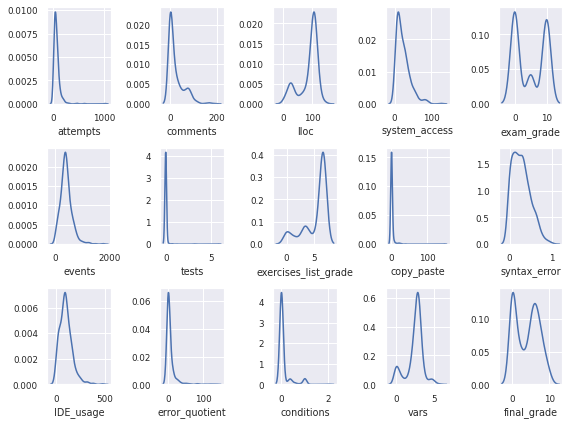

In [ ]:
fig, axs = plt.subplots(nrows=3, ncols=5, figsize=(8, 6))

for i,col in enumerate(dfs['2016'].columns.to_list()):
    row = i//5
    pos = i % 5
    ax = sns.kdeplot(dfs['2016'][col], ax=axs[row][pos])
    #ax = sns.distplot(df[col], ax=axs[row][pos])
    #ax = sns.kdeplot(data=df, x=col, hue="situation", multiple="stack", hue_order=['passed', 'failed'], fill=True, ax=axs[row][pos], legend=False, alpha=.5)
    ax.set_ylabel('')
    
plt.tight_layout()
#plt.savefig('figs/grid_hist9.pdf', format='pdf')

* Applying root square transformation

In [ ]:
for col in ['attempts', 'comments', 'tests', 'copy_paste', 'error_quotient']:
    for i in [6,7,8]:
        dfs["201"+str(i)][col] = dfs["201"+str(i)][col].apply(np.sqrt)
        #dfs["201"+str(i)][col].dropna(inplace=True)

* Standardising the data

In [ ]:
def zscore_transformation(df):
    for col in df.columns[:-1]:
        df[col] = (df[col] - df[col].mean())/df[col].std(ddof=0)

In [ ]:
for i in [6,7,8]:
    zscore_transformation(dfs['201'+str(i)])

In [ ]:
dfs['201'+str(i)].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 454 entries, 0 to 453
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   attempts              454 non-null    float64
 1   comments              454 non-null    float64
 2   lloc                  454 non-null    float64
 3   system_access         454 non-null    float64
 4   exam_grade            454 non-null    float64
 5   events                454 non-null    float64
 6   tests                 454 non-null    float64
 7   exercises_list_grade  454 non-null    float64
 8   copy_paste            454 non-null    float64
 9   syntax_error          454 non-null    float64
 10  IDE_usage             454 non-null    float64
 11  error_quotient        454 non-null    float64
 12  conditions            454 non-null    float64
 13  vars                  454 non-null    float64
 14  final_grade           454 non-null    float64
dtypes: float64(15)
memory u

### Preparing the data for the Predictive Analysis

In [ ]:
def binarise(df):
    df['final_grade_bin'] = 0
    df.loc[df.final_grade>=5.0, 'final_grade_bin'] = 1
    df['final_grade_bin'] = df.final_grade_bin.astype(int)
    return df

In [ ]:
for i in [6,7,8]:
    dfs["201"+str(i)] = binarise(dfs["201"+str(i)])

In [ ]:
for i in [6,7,8]:
    print("201"+str(i))
    print(dfs["201"+str(i)].final_grade_bin.value_counts())

2016
0    238
1    237
Name: final_grade_bin, dtype: int64
2017
1    240
0    212
Name: final_grade_bin, dtype: int64
2018
1    245
0    209
Name: final_grade_bin, dtype: int64


In [ ]:
X_train = dfs["2016"].drop(['final_grade', 'final_grade_bin'], axis=1).values
y_train = dfs["2016"].final_grade_bin.values
X_test = dfs["2017"].drop(['final_grade', 'final_grade_bin'], axis=1).values
y_test = dfs["2017"].final_grade_bin.values

In [ ]:
def print_results(y_true, y_pred):
    print('Acc.:', accuracy_score(y_true, y_pred))
    print(classification_report(y_true, y_pred))
    print('Confusion Matrix:')
    print(confusion_matrix(y_true, y_pred))

### Using default ML algorithms

In [ ]:
feature_selection = [
    None,
    RBFSampler(gamma=0.05),
    RFE(estimator=ExtraTreesClassifier(criterion="gini", n_estimators=100), step=0.5),
    RFE(estimator=ExtraTreesClassifier(criterion="gini", n_estimators=100), step=0.9),
    SelectFdr(score_func=f_classif, alpha=0.01),
    SelectFwe(score_func=f_classif, alpha=0.05),
    SelectKBest(f_classif, k=3),
    SelectKBest(f_classif, k=5),
    SelectKBest(f_classif, k=10),
    SelectPercentile(score_func=f_classif, percentile=80),
    SelectPercentile(score_func=f_classif, percentile=18),
    SelectPercentile(score_func=f_classif, percentile=56)
    ]


predictors = [
    GradientBoostingClassifier(learning_rate=0.001, max_depth=6, max_features=0.4000000000000001, min_samples_split=9, n_estimators=100, subsample=0.8),
    ExtraTreesClassifier(max_features=0.9500000000000001, min_samples_leaf=20, n_estimators=100),
    ExtraTreesClassifier(max_features=0.3500000000000001, min_samples_leaf=20, n_estimators=200),
    RandomForestClassifier(max_features=0.9500000000000001, min_samples_leaf=20, n_estimators=500),
    KNeighborsClassifier(n_neighbors= 5, p= 1, weights= 'distance', n_jobs=-1),
    ExtraTreesClassifier(n_estimators= 400, min_samples_split= 8, bootstrap= False, max_features= 0.6, criterion= 'entropy', min_samples_leaf= 10, max_depth= 7, n_jobs=-1),
    ExtraTreesClassifier(bootstrap= True, max_depth= 4, max_features= 0.85, min_samples_leaf= 5, min_samples_split= 25, criterion= 'gini', n_estimators= 300, n_jobs=-1),
    ExtraTreesClassifier(bootstrap= True, max_depth= 3, max_features= 0.45, min_samples_leaf= 4, min_samples_split= 25, criterion= 'gini', n_estimators= 300, n_jobs=-1),
    RandomForestClassifier(max_features= 0.7, bootstrap= True, max_depth= 7, criterion= 'entropy', min_samples_split= 20, n_estimators= 600, min_samples_leaf= 5, n_jobs=-1),
    RandomForestClassifier(criterion="gini", max_features=0.3, min_samples_leaf=12, min_samples_split=14, n_estimators=100),
    GradientBoostingClassifier(learning_rate=1.0, max_depth=1, max_features=1.0, min_samples_leaf=16, min_samples_split=4, subsample=0.8),
    GradientBoostingClassifier(learning_rate= 0.1, n_estimators= 100, max_depth= 4, subsample= 0.65, min_samples_split= 25, max_features= 0.2),
    GradientBoostingClassifier(min_samples_split= 25, subsample= 0.5, max_features= 0.2, learning_rate= 0.01, n_estimators= 200, max_depth= 4),
    ExtraTreesClassifier(min_samples_split= 16, max_depth= 6, bootstrap= False, max_features= 0.2, n_estimators= 600, min_samples_leaf= 9, criterion= 'entropy', n_jobs=-1),
    ExtraTreesClassifier(n_estimators= 100, min_samples_leaf= 9, max_depth= 5, criterion= 'gini', max_features= 0.4, n_jobs=-1),
    make_pipeline(
        MinMaxScaler(),
        GradientBoostingClassifier(learning_rate=1.0, max_depth=1, max_features=1.0, min_samples_leaf=16,
                                   min_samples_split=4, subsample=0.8)
    ),
    RandomForestClassifier(criterion="gini", max_features=0.3, min_samples_leaf=12, min_samples_split=14, n_estimators=100),
    RandomForestClassifier(bootstrap=True, max_features=0.2, min_samples_leaf=9, min_samples_split=4, n_estimators=100),
    RandomForestClassifier(criterion="entropy", max_features=0.15000000000000002, min_samples_leaf=8,
                           min_samples_split=7),
    ExtraTreesClassifier(bootstrap=False, min_samples_leaf=3, min_samples_split=11, n_estimators=100),
    make_pipeline(
        make_union(
            FunctionTransformer(copy),
            FunctionTransformer(copy)
        ),
        ExtraTreesClassifier(bootstrap=True, criterion="entropy", max_features=0.45, min_samples_leaf=7,
                             min_samples_split=19)
    )
]

In [ ]:
from sklearn.model_selection import StratifiedKFold
split = StratifiedKFold(n_splits=3)

In [ ]:
max_score = 0.0

for f_s in feature_selection:
    for clf in predictors:
        exported_pipeline = make_pipeline(
            f_s, clf
        )
        print(exported_pipeline)
        y_pred = cross_val_predict(exported_pipeline, X_train, y_train, cv=split)
        print_results(y_train, y_pred)
        score = f1_score(y_train, y_pred)
        if score > max_score:
            clf_max = clf
            max_score = score

A saída de streaming foi truncada nas últimas 5000 linhas.
                ('pipeline',
                 Pipeline(memory=None,
                          steps=[('minmaxscaler',
                                  MinMaxScaler(copy=True,
                                               feature_range=(0, 1))),
                                 ('gradientboostingclassifier',
                                  GradientBoostingClassifier(ccp_alpha=0.0,
                                                             criterion='friedman_mse',
                                                             init=None,
                                                             learning_rate=1.0,
                                                             loss='deviance',
                                                             max_depth=1,
                                                             max_features=1.0,
                                                             max_leaf_nodes=None,
  

In [ ]:
clf_max

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=3, min_samples_split=11,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

* Testing in unseen data:

In [ ]:
clf_max.fit(X_train, y_train)
y_pred = clf_max.predict(X_test)
print_results(y_test, y_pred)

Acc.: 0.7212389380530974
              precision    recall  f1-score   support

           0       0.72      0.67      0.69       212
           1       0.72      0.77      0.74       240

    accuracy                           0.72       452
   macro avg       0.72      0.72      0.72       452
weighted avg       0.72      0.72      0.72       452

Confusion Matrix:
[[142  70]
 [ 56 184]]


### Using AutoML

In [ ]:
!pip install tpot

     |████████████████████████████████| 92kB 5.8MB/s 
     |████████████████████████████████| 166.7MB 93kB/s 
     |████████████████████████████████| 163kB 51.4MB/s 
  Created wheel for stopit: filename=stopit-1.1.2-cp37-none-any.whl size=11954 sha256=ef441527e65534f4ebeea5c9bb44db1f22db1fe2eddca66978142be58c5723be
  Stored in directory: /root/.cache/pip/wheels/3c/85/2b/2580190404636bfc63e8de3dff629c03bb795021e1983a6cc7
Successfully built stopit
  Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


In [ ]:
import tpot
from tpot import TPOTClassifier
from tpot.builtins import StackingEstimator

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
model = TPOTClassifier(generations=5, population_size=30, verbosity=2, 
                       cv=3, max_time_mins=10, scoring='recall_weighted', 
                       random_state=7, early_stop=2)

model.fit(X_train, y_train)


Generation 1 - Current best internal CV score: 0.730594697874373

Generation 2 - Current best internal CV score: 0.730594697874373

Generation 3 - Current best internal CV score: 0.730594697874373

The optimized pipeline was not improved after evaluating 2 more generations. Will end the optimization process.

TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: MLPClassifier(GaussianNB(SelectPercentile(input_matrix, percentile=17)), alpha=0.1, learning_rate_init=0.01)


TPOTClassifier(config_dict=None, crossover_rate=0.1, cv=3,
               disable_update_check=False, early_stop=2, generations=5,
               log_file=None, max_eval_time_mins=5, max_time_mins=10,
               memory=None, mutation_rate=0.9, n_jobs=1, offspring_size=None,
               periodic_checkpoint_folder=None, population_size=30,
               random_state=7, scoring='recall_weighted', subsample=1.0,
               template=None, use_dask=False, verbosity=2, warm_start=False)

In [ ]:
y_pred_tpot = model.predict(X_test)
print_results(y_test, y_pred_tpot)

Acc.: 0.7300884955752213
              precision    recall  f1-score   support

           0       0.76      0.63      0.69       212
           1       0.71      0.82      0.76       240

    accuracy                           0.73       452
   macro avg       0.73      0.72      0.72       452
weighted avg       0.73      0.73      0.73       452

Confusion Matrix:
[[133  79]
 [ 43 197]]


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
PATH_TO_W = '/content/drive/MyDrive/Colab Notebooks/ITS - LA course/data/'

* Exporting the best model:

In [ ]:
model.export(PATH_TO_W+'best_model.py')

* Testing again the best model:

In [ ]:
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator
from tpot.export_utils import set_param_recursive

exported_pipeline = make_pipeline(
    SelectPercentile(score_func=f_classif, percentile=17),
    StackingEstimator(estimator=GaussianNB()),
    MLPClassifier(alpha=0.1, learning_rate_init=0.01)
)
# Fix random state for all the steps in exported pipeline
set_param_recursive(exported_pipeline.steps, 'random_state', 7)

exported_pipeline.fit(X_train, y_train)
results = exported_pipeline.predict(X_test)

In [ ]:
y_pred_tpot = model.predict(X_test)
print_results(y_test, y_pred_tpot)

Acc.: 0.7300884955752213
              precision    recall  f1-score   support

           0       0.76      0.63      0.69       212
           1       0.71      0.82      0.76       240

    accuracy                           0.73       452
   macro avg       0.73      0.72      0.72       452
weighted avg       0.73      0.73      0.73       452

Confusion Matrix:
[[133  79]
 [ 43 197]]


* Creating a custumised objective function:

In [ ]:
from sklearn.metrics import make_scorer
from sklearn.metrics import precision_recall_fscore_support

def custom_precision_score(y_true,y_pred):
  precision_tuple, recall_tuple, fscore_tuple, support_tuple = precision_recall_fscore_support(y_true, y_pred)
  fscore_tuple = fscore_tuple[0]
  #support_tuple = support_tuple[0]
  #fscore_tuple = np.average(fscore_tuple, weights=support_tuple)
  return fscore_tuple

custom_scorer = make_scorer(custom_precision_score, greater_is_better=True)

In [ ]:
model = TPOTClassifier(generations=5, population_size=30, verbosity=2, 
                       cv=3, max_time_mins=10, scoring=custom_scorer, 
                       random_state=7, early_stop=2)
model.fit(X_train, y_train)


Generation 1 - Current best internal CV score: 0.6988982470434143

Generation 2 - Current best internal CV score: 0.710758521083268

Generation 3 - Current best internal CV score: 0.7213317722421845

Generation 4 - Current best internal CV score: 0.7213317722421845

Generation 5 - Current best internal CV score: 0.7352094129756929

Best pipeline: MLPClassifier(SelectFromModel(SelectPercentile(Binarizer(input_matrix, threshold=0.4), percentile=17), criterion=gini, max_features=0.8, n_estimators=100, threshold=0.25), alpha=0.1, learning_rate_init=0.01)


TPOTClassifier(config_dict=None, crossover_rate=0.1, cv=3,
               disable_update_check=False, early_stop=2, generations=5,
               log_file=None, max_eval_time_mins=5, max_time_mins=10,
               memory=None, mutation_rate=0.9, n_jobs=1, offspring_size=None,
               periodic_checkpoint_folder=None, population_size=30,
               random_state=7, scoring=make_scorer(custom_precision_score),
               subsample=1.0, template=None, use_dask=False, verbosity=2,
               warm_start=False)

In [ ]:
y_pred_tpot = model.predict(X_test)
print_results(y_test, y_pred_tpot)

Acc.: 0.6703539823008849
              precision    recall  f1-score   support

           0       0.62      0.77      0.69       212
           1       0.74      0.58      0.65       240

    accuracy                           0.67       452
   macro avg       0.68      0.68      0.67       452
weighted avg       0.68      0.67      0.67       452

Confusion Matrix:
[[164  48]
 [101 139]]


### Parameter Tuning with Facets

In [ ]:
!pip install shap

In [ ]:
!pip install lightgbm

In [ ]:
!pip install gamma-facet

In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearndf.pipeline import ClassifierPipelineDF
from sklearndf.classification import RandomForestClassifierDF
from sklearndf.classification import GradientBoostingClassifierDF
from sklearndf.classification import ExtraTreesClassifierDF

# relevant FACET imports
from facet.data import Sample
from facet.selection import LearnerRanker, LearnerGrid

In [ ]:
df_facet = pd.DataFrame(X_train, columns=dfs['2016'].iloc[:,:-2].columns)
df_facet['situation'] = y_train

In [ ]:
# create FACET sample object
situation_sample = Sample(df_facet, target_name='situation')

In [ ]:
from sklearndf.classification.extra import LGBMClassifierDF

cv_approach = RepeatedStratifiedKFold(n_splits=3, n_repeats=5, random_state=7)

lgbm_clf = ClassifierPipelineDF(
    classifier=LGBMClassifierDF(random_state=7),
)

rnd_forest = ClassifierPipelineDF(
    classifier=RandomForestClassifierDF(random_state=7)
)

ext_forest = ClassifierPipelineDF(
    classifier=ExtraTreesClassifierDF(random_state=7)
)

clf_grid = [
    LearnerGrid(
        pipeline=rnd_forest, 
        learner_parameters={ 
            "max_features":[0.2,0.5,0.8],
            "n_estimators":[100,500],
            "min_samples_leaf":[3,9,20],
            "max_depth": [None, 2, 4, 6],
        }
    ),
    LearnerGrid(
        pipeline=lgbm_clf, 
        learner_parameters={ 
            "num_leaves": [5,50,100],
            "learning_rate": [0.01,0.05,0.1],
            "n_estimators":[100,500],
        }
    ),
    LearnerGrid(
        pipeline=ext_forest, 
        learner_parameters={ 
            "max_features":[0.2,0.5,0.8],
            "n_estimators":[100,500],
            "min_samples_leaf":[3,9,20],
            "max_depth": [None, 2, 4, 6]
        }
    )
]

model_ranker = LearnerRanker( 
    grids=clf_grid, cv=cv_approach, n_jobs=-3
).fit(sample=situation_sample)

model_ranker.summary_report()

ranking_score accuracy_score            ... classifier                         
                             mean       std  ...  max_depth num_leaves learning_rate
rank                                         ...                                    
0         0.692543       0.729260  0.018359  ...        NaN        NaN           NaN
1         0.691801       0.729265  0.018732  ...        6.0        NaN           NaN
2         0.690822       0.729674  0.019426  ...        4.0        NaN           NaN
3         0.690292       0.727991  0.018850  ...        NaN        NaN           NaN
4         0.689508       0.728416  0.019454  ...        6.0        NaN           NaN
...            ...            ...       ...  ...        ...        ...           ...
157       0.649591       0.700600  0.025504  ...        NaN       50.0          0.05
158       0.649591       0.700600  0.025504  ...        NaN      100.0          0.05
159       0.647997       0.729687  0.040845  ...        NaN        NaN           NaN
160       0.646507       0.704811  0.029152  ...        NaN        5.0          0.10
161       0.644871       0.702274  0.028702  ...        NaN        5.0          0.05

[162 rows x 10 columns]

### Using SHAP

In [ ]:
import shap

In [ ]:
clf = RandomForestClassifier(min_samples_leaf = 9, n_estimators=500, max_features=0.5)

In [ ]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=0.5,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=9, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
y_prob = clf.predict_proba(X_test)
y_prob[:5,:]

array([[0.89092187, 0.10907813],
       [0.3676936 , 0.6323064 ],
       [0.44063656, 0.55936344],
       [0.45731005, 0.54268995],
       [0.2207947 , 0.7792053 ]])

In [ ]:
cols_display = dfs['2016'].drop(['final_grade', 'final_grade_bin'], axis=1).columns.to_list()

In [ ]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_train)

In [ ]:
explainer.expected_value

array([0.4996, 0.5004])

In [ ]:
shap_values[1]

array([[-0.00407685,  0.01868307,  0.00438802, ..., -0.00279485,
        -0.00182513,  0.00794079],
       [-0.00291092, -0.00061381, -0.16130903, ..., -0.00376871,
        -0.00031175, -0.04172162],
       [-0.03013442,  0.01617384,  0.09975304, ..., -0.00361658,
        -0.00399653,  0.01414332],
       ...,
       [ 0.01155212, -0.0031633 , -0.12769159, ...,  0.00489074,
        -0.00040881, -0.04218676],
       [ 0.00659166, -0.01981294,  0.01725797, ..., -0.00231965,
        -0.00084586,  0.0201866 ],
       [-0.00322313, -0.03248437, -0.09280528, ..., -0.00384869,
        -0.00047656, -0.08014355]])

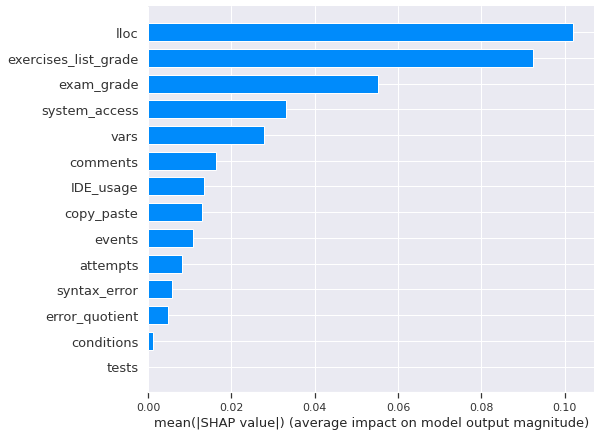

In [ ]:
#f = plt.figure()
shap.summary_plot(shap_values[1],X_train, plot_type="bar", feature_names=cols_display)
#f.savefig(PATH+'fig_feature_importance.pdt', bbox_inches='tight', format='pdf')

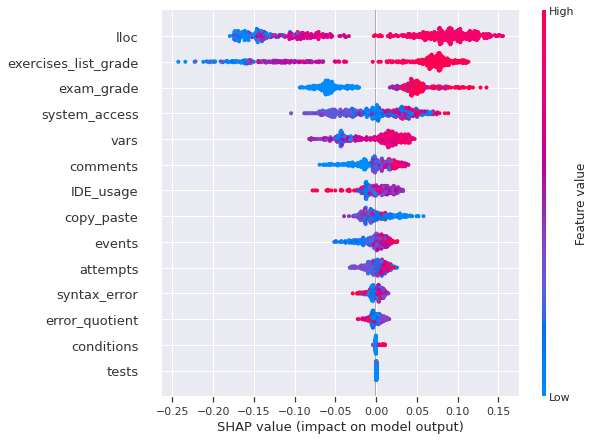

In [ ]:
shap.summary_plot(shap_values[1], X_train, feature_names=cols_display)

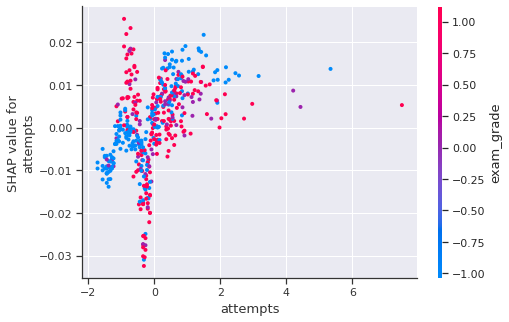

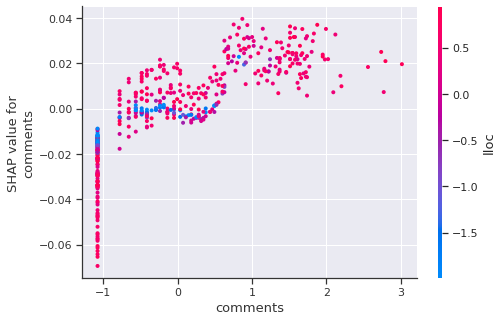

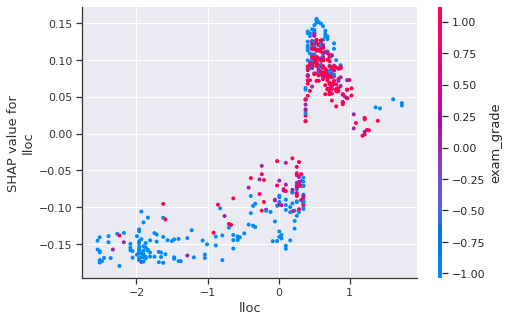

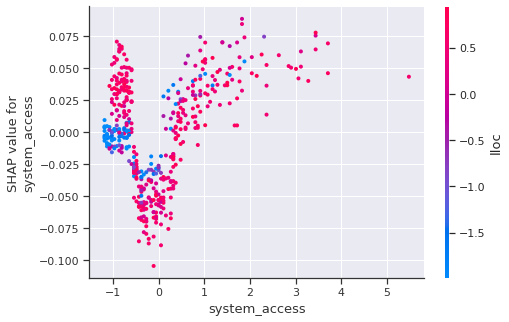

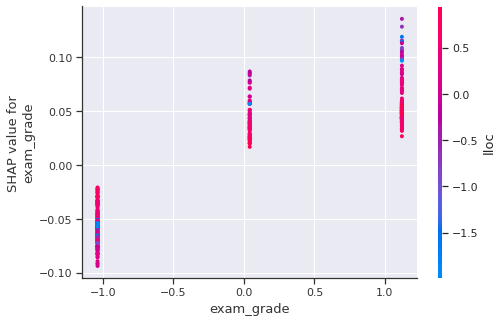

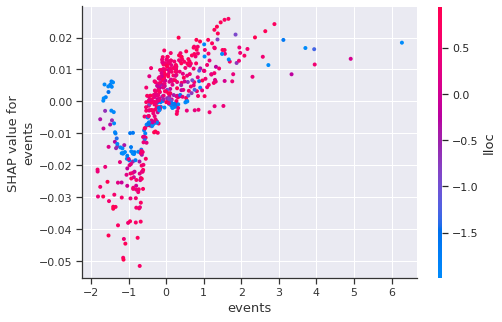

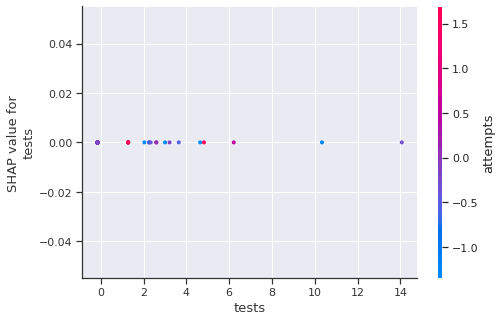

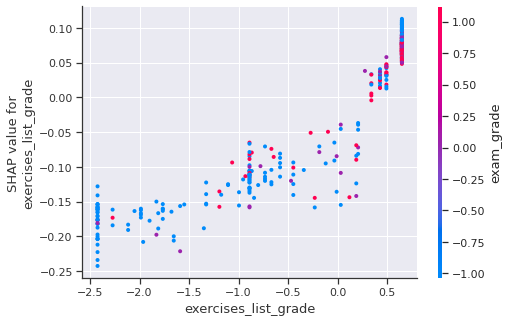

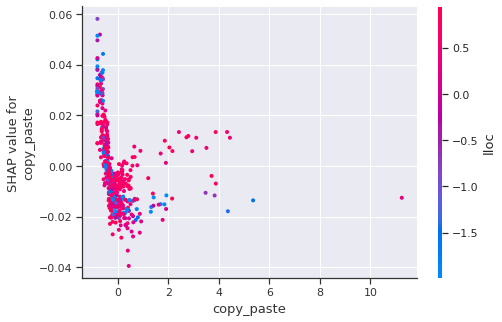

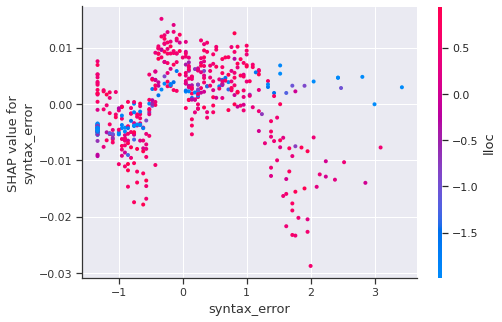

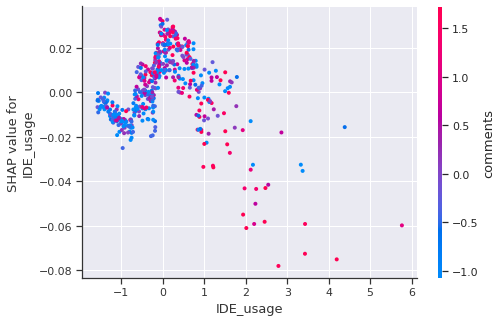

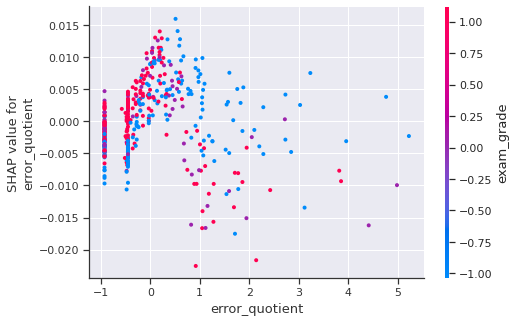

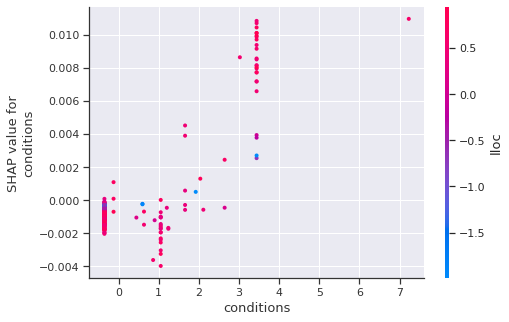

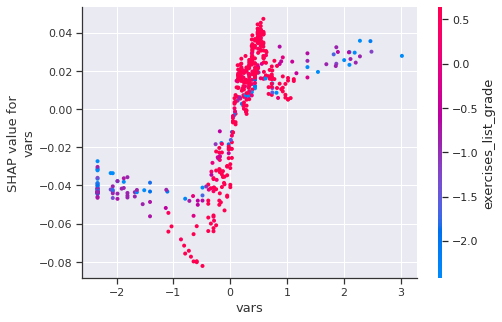

In [ ]:
for col in cols_display:
    shap.dependence_plot(col, shap_values[1], X_train, show=False, feature_names=cols_display)

In [ ]:
shap_values_1 = shap_values[1]#shap values for class 1

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values_1[0,:], X_train[0,:], feature_names=cols_display)

In [ ]:
shap.initjs()
instance = 30
shap.force_plot(explainer.expected_value[1], shap_values_1[instance,:], X_train[instance,:], feature_names=cols_display)

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values_1, X_train, feature_names=cols_display)